We found this dataset on internet which has the Text as "Tweets" and stock data for several tickers.

### Imports

In [65]:
#! pip install transformers
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import matplotlib.pyplot as plt
import csv
from matplotlib.dates import DateFormatter
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

### Our data

In [12]:
stock_name = 'TSLA'

In [24]:
all_tweets = pd.read_csv('/content/stock_tweets.csv', encoding='utf-8')

In [35]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [36]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(37422, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [37]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",


### sentiment analysis using previously analysed models

In [38]:
def distilbert(data_frame):
  classifier = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")
  for index, row in tqdm(data_frame.iterrows(), total=len(data_frame)):
    text = row['Tweet']
    score = classifier(text)
    row["sentiment_score"] = score[0]['score']

  return data_frame

In [39]:
sent_df = distilbert(sent_df)
sent_df.head()


  0%|          | 0/37422 [00:00<?, ?it/s]

,Date,Tweet,Stock Name,Company Name,sentiment_score
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.86497
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.994571
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.99851
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",0.998553
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",0.993832


In [44]:
sent_df.to_csv('file1.csv')

In [45]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Stock Name', 'Company Name'])
sent_df.head()

,Date,Tweet,sentiment_score
0,2022-09-29,Mainstream media has done an amazing job at br...,0.86497
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,0.994571
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,0.99851
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.998553
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.993832


In [46]:
twitter_df = sent_df.groupby([sent_df['Date']]).mean()
print(twitter_df.shape)
twitter_df.head()

(365, 1)


<ipython-input-46-66407eaab9f4>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  twitter_df = sent_df.groupby([sent_df['Date']]).mean()


,sentiment_score
Date,
2021-09-30,0.935693
2021-10-01,0.958558
2021-10-02,0.957919
2021-10-03,0.979918
2021-10-04,0.976944


### Load the stocks dataset

In [47]:
all_stocks = pd.read_csv('/content/stock_yfinance_data.csv', encoding='utf-8')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [48]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

<ipython-input-48-80f1f64a5884>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])
<ipython-input-48-80f1f64a5884>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'] = stock_df['Date'].dt.date


### combine datasets

In [52]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)
final_df

(252, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.935693
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.958558
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.976944
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.952934
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.964329
...,...,...,...,...,...,...,...,...
247,2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,0.964044
248,2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,0.964961
249,2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,0.965680
250,2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,0.967617


### plotting data

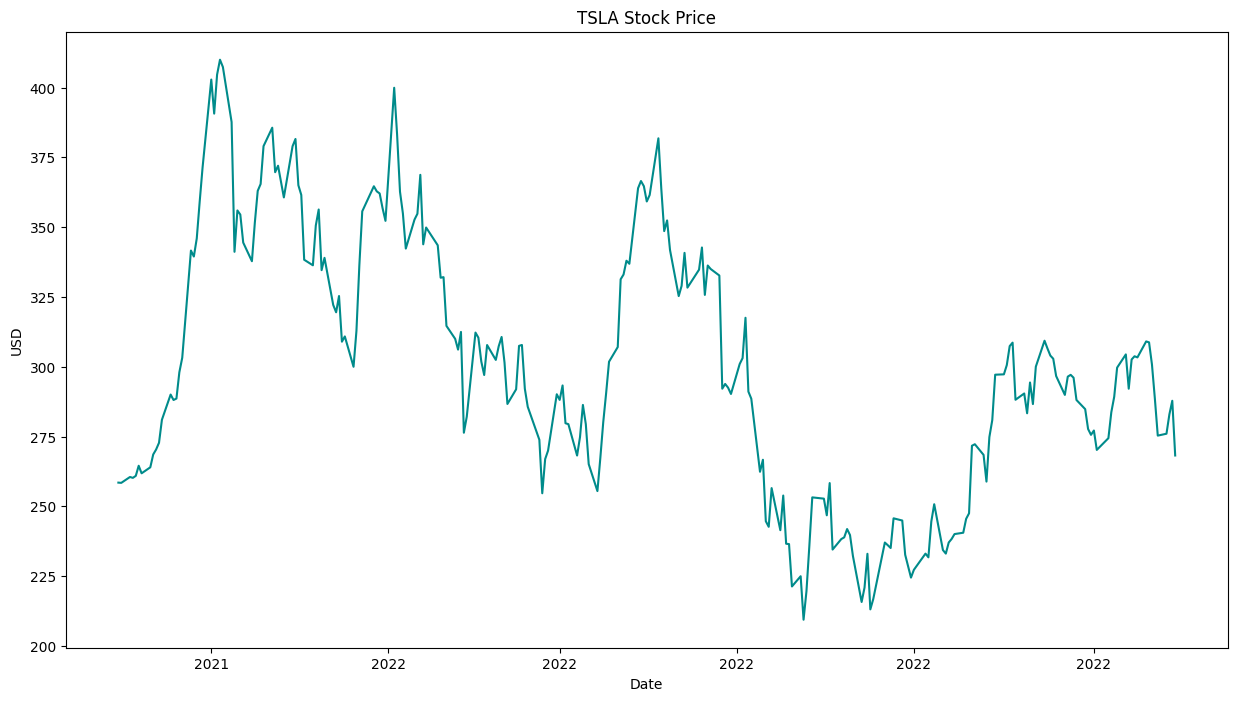

In [53]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

### adding technical indicators 

To help the network understand the bigger picture of the market we add different technical indicators to the training data, such as moving averages, Bollinger bands etc., which describe the development of stock price not only for the current day, but for the past week or more.

*   MA(7) stans for Moving Average for past 7 days
*   MA (20) means Moving Average for past 20 days.

EMA is Exponential Moving average and we can calculate it as:

*   EMA_t = Pclose + (EMA_t-1 (100 - P))*

Bollinger Bands are calculated as:

*   middle line: stdev(MA(20))
*   upper bound: MA(20) + 2stdev(MA(20))
*   lower bound: MA(20) - 2stdev(MA(20))

In [54]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column
    
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [206]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,0.953962,325.127141,288.855501,-9.269895,32.580099,354.015698,223.695304,353.510805,5.880570
1,2021-10-29,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,0.961821,336.946189,294.501834,-10.609662,36.566908,367.635649,221.368019,365.392497,5.914404
2,2021-11-01,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,0.963786,351.926666,301.619501,-11.860446,42.906989,387.433479,215.805523,390.373061,5.996112
3,2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,0.958847,364.418095,308.143001,-14.295169,46.078655,400.300312,215.985690,390.568791,5.965292
4,2021-11-03,392.443329,405.130005,384.206665,404.619995,404.619995,103885500,0.961477,373.418095,315.328168,-15.716662,49.410503,414.149173,216.507162,399.936260,6.000474


In [207]:
dataset = dataset.drop(columns=['Open',	'High',	'Low', 'Adj Close',	'Volume','sentiment_score','MA7',	'MA20'	,'MACD',	'20SD',	'upper_band',	'lower_band',	'EMA',	'logmomentum'])
dataset

,Date,Close
0,2021-10-28,359.013336
1,2021-10-29,371.333344
2,2021-11-01,402.863342
3,2021-11-02,390.666656
4,2021-11-03,404.619995
...,...,...
227,2022-09-23,275.329987
228,2022-09-26,276.010010
229,2022-09-27,282.940002
230,2022-09-28,287.809998


In [208]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

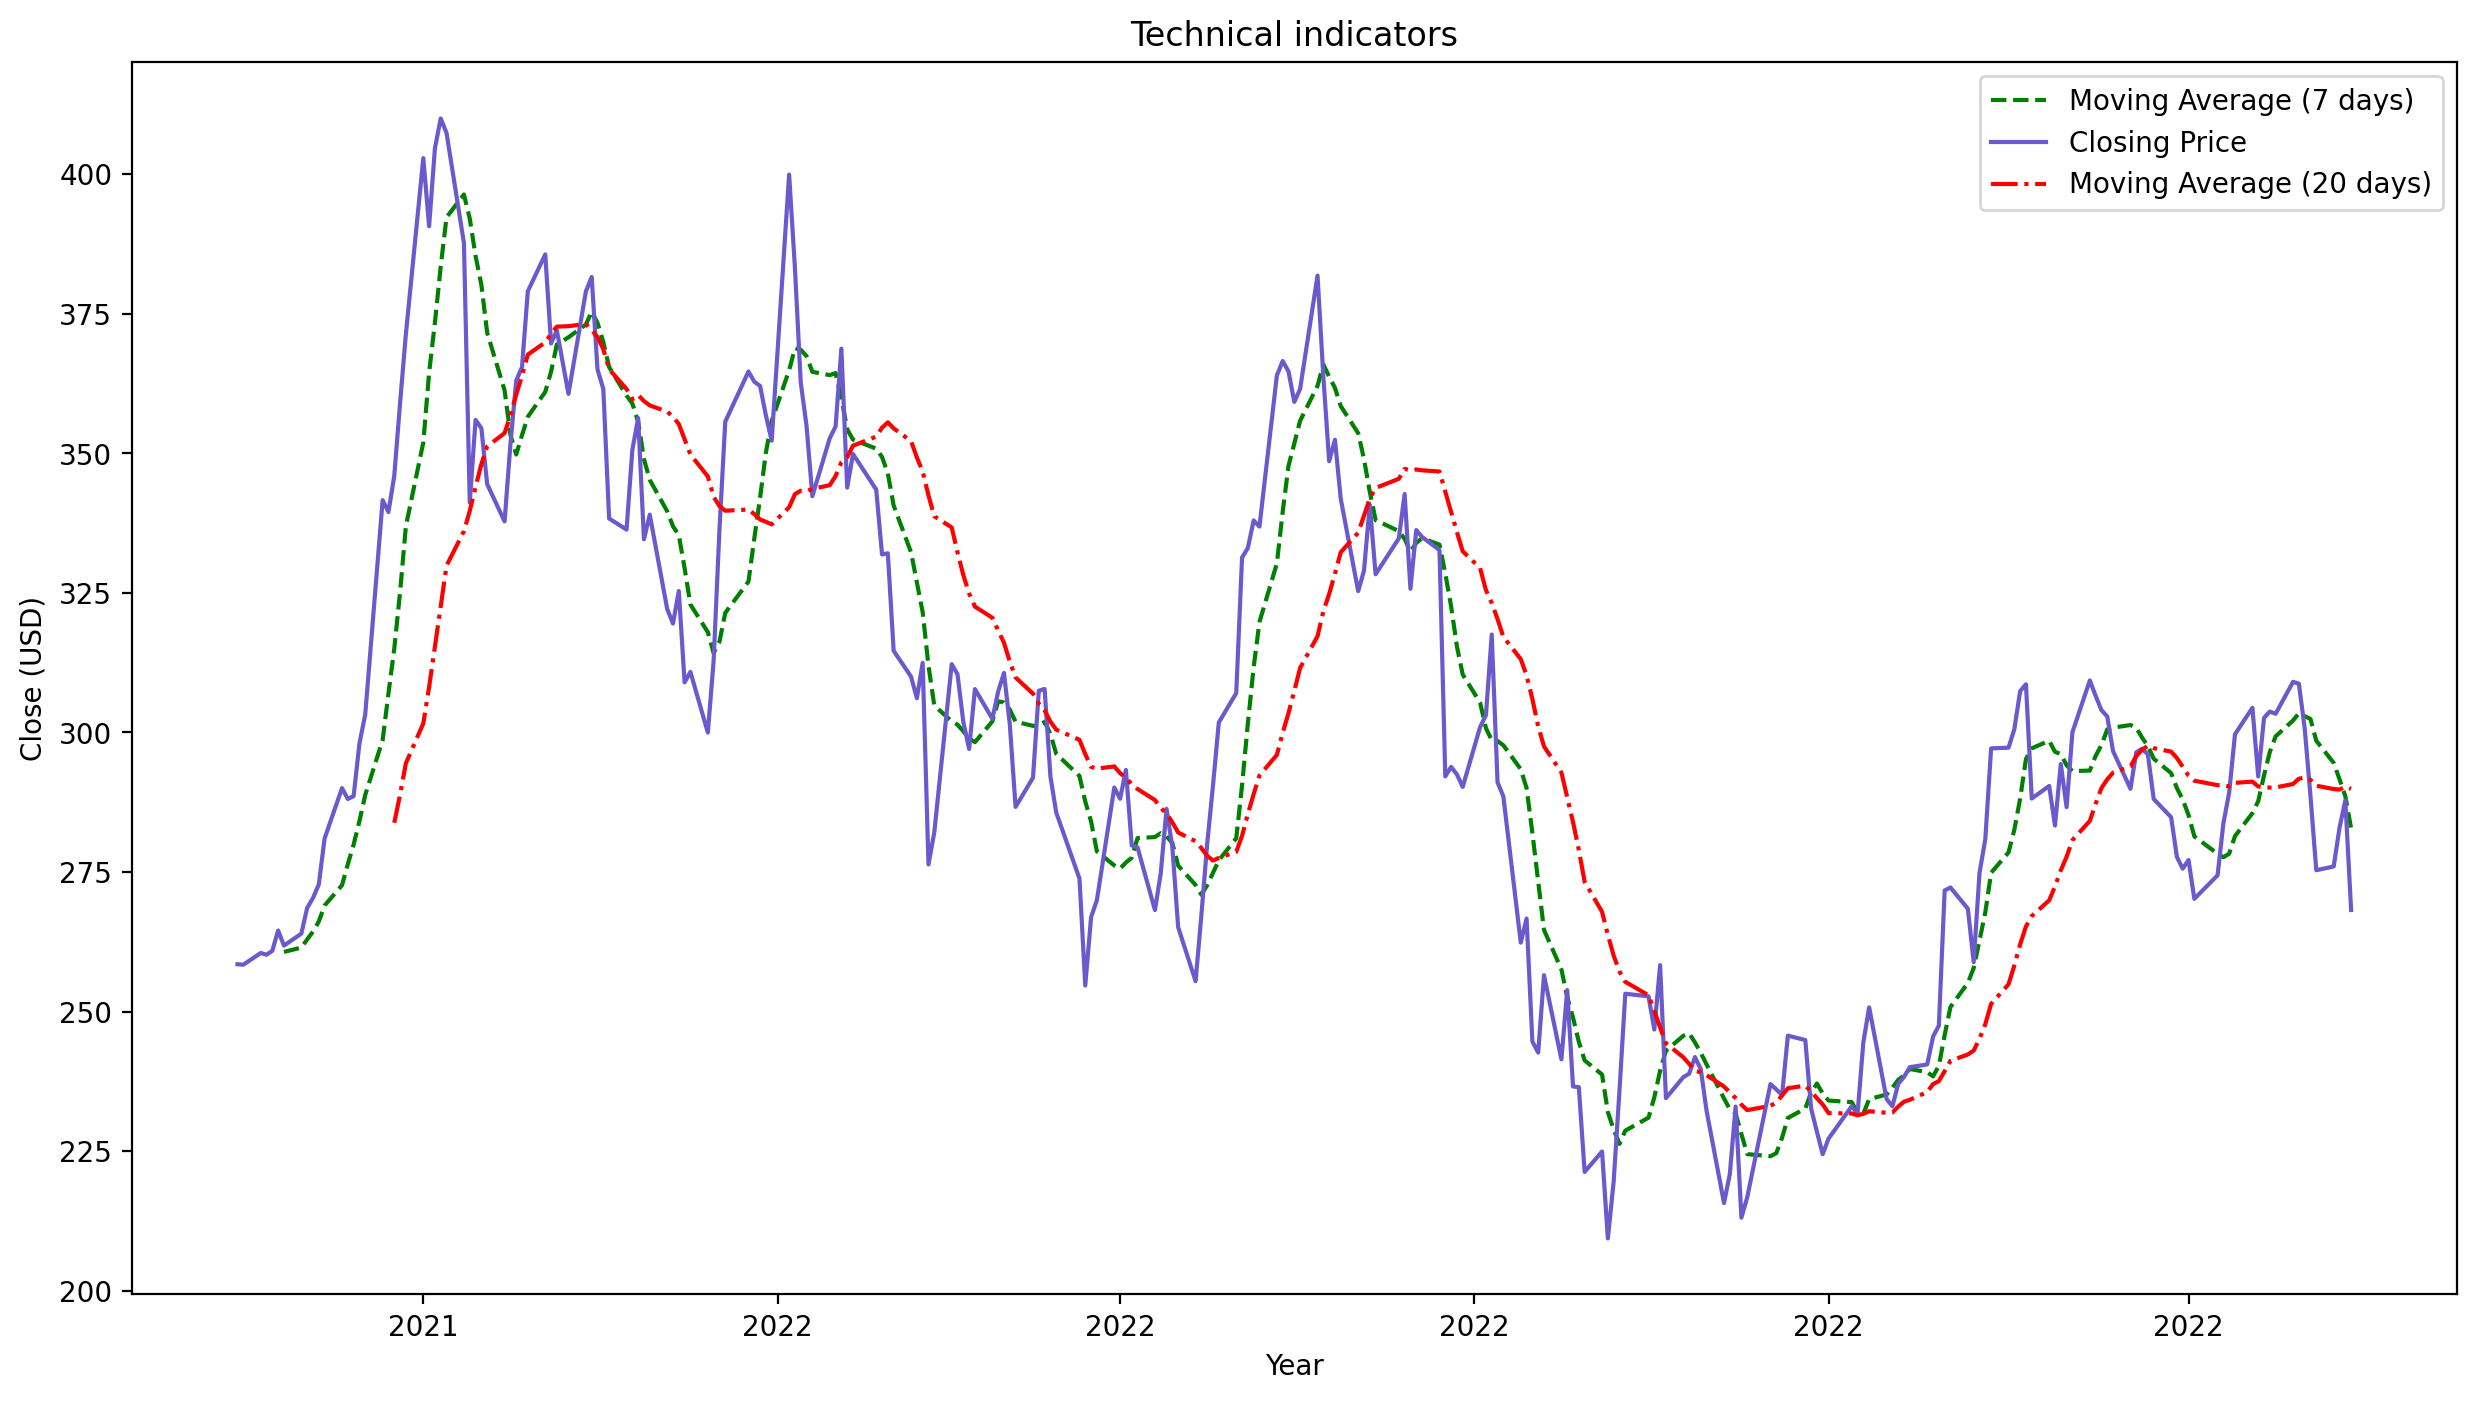

In [184]:
tech_ind(tech_df)

In [185]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [209]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [210]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [211]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [212]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [213]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [214]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 1)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [215]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

### Build LSTM Model 

In [216]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [217]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [218]:
print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape) 

Training Shape torch.Size([207, 5, 1]) torch.Size([207, 1])
Testing Shape torch.Size([20, 5, 1]) torch.Size([20, 1])


In [219]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [220]:
num_epochs = 1000 #100 epochs
learning_rate = 0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [221]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[1]) #our lstm class

In [222]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [223]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 10 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.25648
Epoch: 10, loss: 0.22201
Epoch: 20, loss: 0.22249
Epoch: 30, loss: 0.21926
Epoch: 40, loss: 0.21592
Epoch: 50, loss: 0.21114
Epoch: 60, loss: 0.20327
Epoch: 70, loss: 0.19125
Epoch: 80, loss: 0.17415
Epoch: 90, loss: 0.15245
Epoch: 100, loss: 0.12715
Epoch: 110, loss: 0.10072
Epoch: 120, loss: 0.07595
Epoch: 130, loss: 0.05524
Epoch: 140, loss: 0.04180
Epoch: 150, loss: 0.03563
Epoch: 160, loss: 0.03357
Epoch: 170, loss: 0.03264
Epoch: 180, loss: 0.03187
Epoch: 190, loss: 0.03116
Epoch: 200, loss: 0.03050
Epoch: 210, loss: 0.02979
Epoch: 220, loss: 0.02912
Epoch: 230, loss: 0.02850
Epoch: 240, loss: 0.02793
Epoch: 250, loss: 0.02740
Epoch: 260, loss: 0.02691
Epoch: 270, loss: 0.02643
Epoch: 280, loss: 0.02596
Epoch: 290, loss: 0.02547
Epoch: 300, loss: 0.02493
Epoch: 310, loss: 0.02437
Epoch: 320, loss: 0.02388
Epoch: 330, loss: 0.02343
Epoch: 340, loss: 0.02302
Epoch: 350, loss: 0.02264
Epoch: 360, loss: 0.02228
Epoch: 370, loss: 0.02193
Epoch: 380, loss: 0.021

In [224]:
y_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler.fit(pd.DataFrame(dataset["Close"]))

MinMaxScaler(feature_range=(-1, 1))

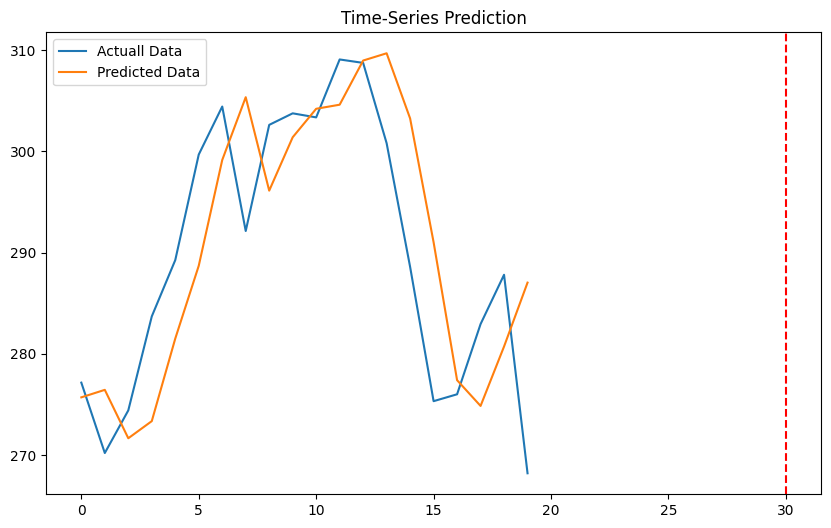

In [225]:
train_predict = lstm1(X_test_tensors)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_test_tensors.data.numpy()

data_predict = y_scaler.inverse_transform(data_predict) #reverse transformation
dataY_plot = y_scaler.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=30, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [226]:
def mse(y, y_hat):
    return np.mean(np.square(y - y_hat))
print("MSE-->",mse(dataY_plot,data_predict))

MSE--> 80.93484


In [227]:
dataset

,Close
2021-10-28,359.013336
2021-10-29,371.333344
2021-11-01,402.863342
2021-11-02,390.666656
2021-11-03,404.619995
...,...
2022-09-23,275.329987
2022-09-26,276.010010
2022-09-27,282.940002
2022-09-28,287.809998
